The goal is to create an animation which shows the flow rates inside the map over time. <br>
The data will be divided into intervals (30s) and then a heatmap will be calculated. 
<br>
<br>
Also: Grouping brings interesting insights in terms of flow rates: mean, maximum, std etc... also people per second

In [1]:
# imports
import json
from datetime import datetime
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
import io
from IPython.display import display
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from tqdm import tqdm

In [2]:
# load data
filepath = 'raw_data.json'
with open(filepath) as f:
    data = json.load(f)

# test access
print(data.keys())

dict_keys(['05. Dec (Thursday)', '18. Dec (Wednesday)'])


In [3]:
# Cut data (Code from Elias)
def cut_data(data, cut_start, cut_end):
    return [timestamp for timestamp in data if timestamp >= cut_start and timestamp <= cut_end]

cut_start = 1734519960000 # 12:06
cut_end = 1734520799000 # 12:19:59

for spot in data["18. Dec (Wednesday)"]:
    if spot == "Metadata":
        continue
    data["18. Dec (Wednesday)"][spot] = cut_data(data["18. Dec (Wednesday)"][spot], cut_start, cut_end)

In [4]:
# get the keys
print(data.keys())
# start with the first day
first_day = data['05. Dec (Thursday)']
second_day = data['18. Dec (Wednesday)']
print(first_day.keys())

# Test the timestamps
t = first_day['Day_Menu']
print(t)

dict_keys(['05. Dec (Thursday)', '18. Dec (Wednesday)'])
dict_keys(['Metadata', 'Cash_T', 'Cash_B', 'Entrance_R', 'Entrance_L', 'Auswahl', 'Day_Menu', 'Veggie', 'Veggie_Cash_R', 'Veggie_Cash_L'])
[1733396056798, 1733396059557, 1733396063208, 1733396065742, 1733396069409, 1733396082796, 1733396098166, 1733396101049, 1733396125272, 1733396129105, 1733396141941, 1733396163947, 1733396172664, 1733396177049, 1733396197903, 1733396199470, 1733396201504, 1733396216941, 1733396221259, 1733396238489, 1733396254819, 1733396261354, 1733396278558, 1733396284343, 1733396288527, 1733396295445, 1733396299096, 1733396312766, 1733396319200, 1733396326803, 1733396330186, 1733396354973, 1733396362259, 1733396365644, 1733396370844, 1733396378180, 1733396396033, 1733396397467, 1733396409903, 1733396420261, 1733396425527, 1733396428212, 1733396434363, 1733396450048, 1733396452467, 1733396456802, 1733396462118, 1733396467103, 1733396486058, 1733396492492, 1733396502644, 1733396508712, 1733396512079, 17333965

In [5]:
# datetime can be used to convert timestamps
# timestamps are in milliseconds
# for datetime we need seconds
# so we divide by 1000
dt = datetime.fromtimestamp(t[0] / 1000)
print(dt)

2024-12-05 11:54:16.798000


In [6]:
# group into groups of 30 seconds
def group_timestamps(timestamps, group_window=30, starter=None, end=None):
    groups = []
    # First, convert all timestamps into seconds
    timestamps = [t // 1000 for t in timestamps]
    # Use sorted list to make it easier
    timestamps = sorted(timestamps) 
    if starter is None:
        group_starter = timestamps[0]
    else:
        group_starter = starter // 1000
    if end is None:
        group_end = timestamps[-1]
    else:
        group_end = end // 1000
    group = []
    for t in timestamps:
        if t - group_starter < group_window:
            group.append(t)
        else:
            groups.append(group)
            group_starter = group_starter + group_window
            group = []
            
            while t - group_starter >= group_window:
                groups.append([])
                group_starter = group_starter + group_window

            group.append(t)

    # pad until end
    while group_starter + group_window <= group_end:
        groups.append([])
        group_starter = group_starter + group_window

    # Add the last group
    groups.append(group)
    return groups

In [7]:
print(second_day.keys())

dict_keys(['Metadata', 'Entrance_R', 'Entrance_L', 'Cutlery', 'Auswahl', 'Day_Menu', 'Cash_T', 'Cash_B', 'Veggie', 'Veggie_Cash_R', 'Veggie_Cash_L'])


In [8]:
# Find earliest datapoints
keys = ['Cash_T', 'Cash_B', 'Entrance_R', 'Entrance_L', 'Auswahl', 'Day_Menu', 'Veggie', 'Veggie_Cash_R', 'Veggie_Cash_L']
earliest = float('inf')
for k in keys:
    ts = sorted(first_day[k])[0]
    if ts < earliest:
        earliest = ts

earliest_frist_day = earliest

keys = ['Entrance_R', 'Entrance_L', 'Cutlery', 'Auswahl', 'Day_Menu', 'Cash_T', 'Cash_B', 'Veggie', 'Veggie_Cash_R', 'Veggie_Cash_L']
earliest = float('inf')
for k in keys:
    ts = sorted(second_day[k])[0]
    if ts < earliest:
        earliest = ts

earliest_second_day = earliest

print(datetime.fromtimestamp(earliest_frist_day // 1000), datetime.fromtimestamp(earliest_second_day // 1000))

# based on that, begin grouping with 11:54 and 12:05

2024-12-05 11:54:06 2024-12-18 12:06:00


In [9]:
start_frist_day = datetime(2024, 12, 5, 11, 54, 0).timestamp() * 1000
start_second_day = datetime(2024, 12, 18, 12, 5, 0).timestamp() * 1000
print(datetime.fromtimestamp(start_frist_day // 1000), datetime.fromtimestamp(start_second_day // 1000))

2024-12-05 11:54:00 2024-12-18 12:05:00


In [10]:
# Use Eliases Values instead
start_second_day = cut_start

In [11]:
# group all data
keys = ['Cash_T', 'Cash_B', 'Entrance_R', 'Entrance_L', 'Auswahl', 'Day_Menu', 'Veggie', 'Veggie_Cash_R', 'Veggie_Cash_L']
first_day_grouped = {}
for k in keys:
    first_day_grouped[k] = group_timestamps(first_day[k], starter=start_frist_day)

keys = ['Entrance_R', 'Entrance_L', 'Cutlery', 'Auswahl', 'Day_Menu', 'Cash_T', 'Cash_B', 'Veggie', 'Veggie_Cash_R', 'Veggie_Cash_L']
second_day_grouped = {}
for k in keys:
    second_day_grouped[k] = group_timestamps(second_day[k], starter=start_second_day, end=cut_end)

print(first_day_grouped)

{'Cash_T': [[], [], [1733396115, 1733396120, 1733396120, 1733396121, 1733396124, 1733396127], [1733396134, 1733396150, 1733396156], [], [1733396202], [1733396235, 1733396242], [1733396258, 1733396260, 1733396266, 1733396276], [1733396285], [1733396329, 1733396335], [], [1733396383, 1733396398], [1733396402, 1733396405, 1733396419], [1733396456, 1733396459], [], [1733396499, 1733396500, 1733396516, 1733396517], [1733396538, 1733396541], [1733396561], [1733396588, 1733396590], [1733396628, 1733396630], [1733396640, 1733396647, 1733396661, 1733396669], [1733396680, 1733396683, 1733396690], [1733396715, 1733396719, 1733396722], [1733396735, 1733396755], [1733396778], [1733396792, 1733396795], [1733396832], [1733396851, 1733396853, 1733396865, 1733396878], [], [1733396911], [1733396940, 1733396950, 1733396963], [1733396975, 1733396997], [1733397002, 1733397028], [], [1733397070], [1733397107], [1733397120, 1733397126, 1733397146, 1733397148], [1733397150], [1733397182, 1733397204], [1733397

In [12]:
keys_first_day = ['Cash_T', 'Cash_B', 'Entrance_R', 'Entrance_L', 'Auswahl', 'Day_Menu', 'Veggie', 'Veggie_Cash_R', 'Veggie_Cash_L']
keys_second_day = ['Entrance_R', 'Entrance_L', 'Cutlery', 'Auswahl', 'Day_Menu', 'Cash_T', 'Cash_B', 'Veggie', 'Veggie_Cash_R', 'Veggie_Cash_L']

In [13]:
# Print how many groups we have
for k in keys_first_day:
    print(k, len(first_day_grouped[k]))

Cash_T 58
Cash_B 68
Entrance_R 68
Entrance_L 62
Auswahl 61
Day_Menu 63
Veggie 63
Veggie_Cash_R 63
Veggie_Cash_L 63


Maybe we need to pad smaller groups (finished earlier) to have the same length as the longest goup

In [14]:
# find mean and maximum values

# for both days
mean = 0
number = 0
maximum = 0
for k in keys_first_day:
    for group in first_day_grouped[k]:
        mean += len(group)
        number += 1

        if len(group) > maximum:
            maximum = len(group)

for k in keys_second_day:
    for group in second_day_grouped[k]:
        mean += len(group)
        number += 1

        if len(group) > maximum:
            maximum = len(group)

mean = mean / number

print(f"Mean group length: {mean}, Maximum group length: {maximum}")

Mean group length: 2.3769140164899882, Maximum group length: 14


# Visualize one timeframe

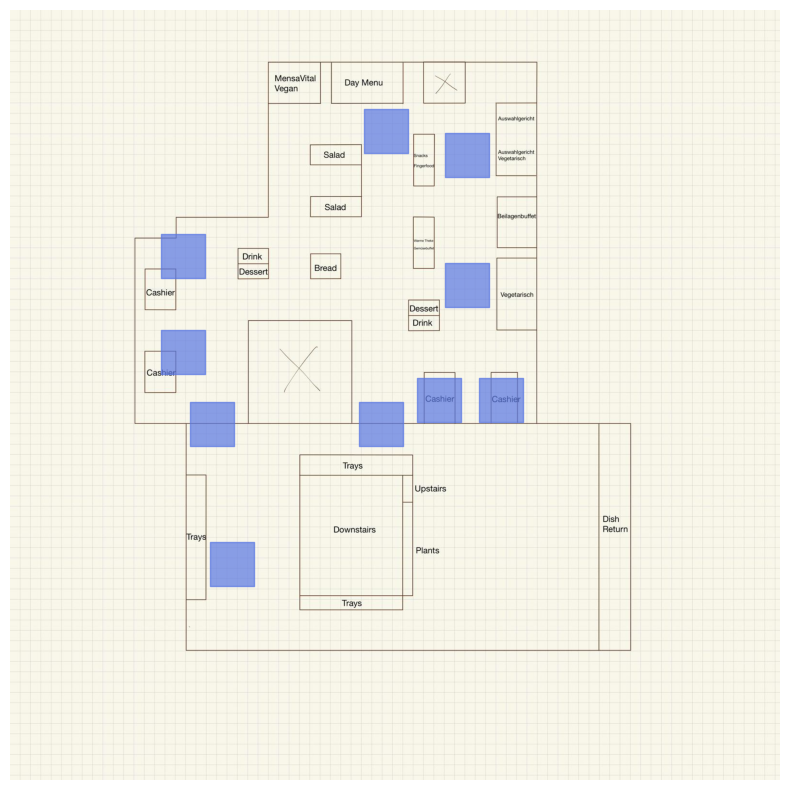

In [15]:
image_path = 'map.jpeg'
image = Image.open(image_path)
BACKGROUND_IMAGE = Image.open(image_path)

points = [
    (780, 250),  # Daily menu
    (950, 300),  # Auswahl
    (950, 570),  # Veggie
    (1020, 810), # Veggie Cash R
    (890, 810),  # Veggie Cash L
    (770, 860),  # Entance R
    (420, 860),  # Entance L
    (360, 510),  # Day cash T
    (360, 710),  # Day cash B
    (460, 1150)   # Cuttlery
]

# plot image
plt.figure(figsize=(10, 10))
plt.imshow(image)

# add the points
for x,y in points:
    # noramlize values (TODO:)
    # make them between 0 and 1
    color = plt.cm.coolwarm(0.1)
    plt.scatter(
        x, y, color=color, s=200 * 5, marker='s', alpha=0.7
    )

# Display image
plt.axis('off')
plt.show()

63
{'Cutlery': 0, 'Cash_T': 4, 'Cash_B': 4, 'Entrance_R': 7, 'Entrance_L': 4, 'Auswahl': 1, 'Day_Menu': 6, 'Veggie': 5, 'Veggie_Cash_R': 0, 'Veggie_Cash_L': 2}


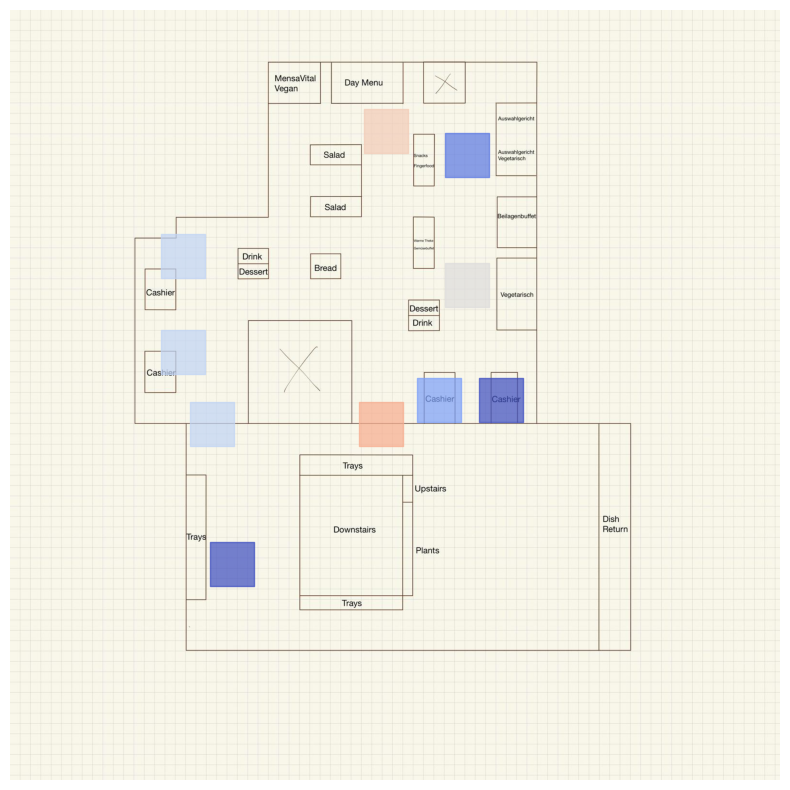

In [16]:
def plot_data(timeframe_data):
    '''
    Plots one timeframe, needs data as a dict of length values:
    {
        'Cash_T': 1,
        'Cash_B': 5,
        ...
    }
    '''

    points = {
        'Day_Menu': (780, 250),
        'Auswahl': (950, 300),
        'Veggie': (950, 570),
        'Veggie_Cash_R': (1020, 810),
        'Veggie_Cash_L': (890, 810),
        'Entrance_R': (770, 860),
        'Entrance_L': (420, 860),
        'Cash_T': (360, 510),
        'Cash_B': (360, 710),
        'Cutlery': (460, 1150)
    }

    # plot image
    plt.figure(figsize=(10, 10))
    plt.imshow(image)

    # add the points
    for k in keys_second_day:
        maximum = 10 # value for red Color
        color = plt.cm.coolwarm(timeframe_data[k] / maximum)
        x, y = points[k]
        plt.scatter(
            x, y, color=color, s=200 * 5, marker='s', alpha=0.7
        )

    # Display image
    plt.axis('off')
    plt.show()

first_day_sizes = {}
first_day_sizes['Cutlery'] = 0

# take one timestep e.g. the 20th
print(len(first_day_grouped['Day_Menu']))

for k in keys_first_day:
    first_day_sizes[k] = len(first_day_grouped[k][20])

print(first_day_sizes)
plot_data(first_day_sizes)

In [17]:
POINTS_COORDS = {
        'Day_Menu': (780, 250),
        'Auswahl': (950, 300),
        'Veggie': (950, 570),
        'Veggie_Cash_R': (1020, 810),
        'Veggie_Cash_L': (890, 810),
        'Entrance_R': (770, 860),
        'Entrance_L': (420, 860),
        'Cash_T': (360, 510),
        'Cash_B': (360, 710),
        'Cutlery': (460, 1150)
    }

For the animation, first save a time-series of numbers and then animate that series, to include smooth transitions
(use 18.12.)

In [18]:
for spot in keys_second_day:
    print(len(second_day_grouped[spot]))

28
28
28
28
28
28
28
28
28
28


In [19]:
# transform into list of people per timeframe
second_day_pptf = {}
for spot in keys_second_day:
    second_day_pptf[spot] = []
    for timeframe in second_day_grouped[spot]:
        second_day_pptf[spot].append(len(timeframe))

In [20]:
# create animation by adding interpolated values between datapoints
def add_interpolation(data, number_artificial_points=10):
    new_data = {}
    for spot in data:
        new_data[spot] = []
        for i in range(len(data[spot]) - 1):
            for j in range(number_artificial_points + 1):
                new_data[spot].append(data[spot][i] + (data[spot][i + 1] - data[spot][i]) * j / number_artificial_points)
    
    return new_data

interpolated_data = add_interpolation(second_day_pptf)
print(interpolated_data)

{'Entrance_R': [8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 7.6, 7.2, 6.8, 6.4, 6.0, 5.6, 5.2, 4.8, 4.4, 4.0, 4.0, 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.3, 5.6, 5.9, 6.2, 6.5, 6.8, 7.1, 7.4, 7.7, 8.0, 8.0, 7.9, 7.8, 7.7, 7.6, 7.5, 7.4, 7.3, 7.2, 7.1, 7.0, 7.0, 6.4, 5.8, 5.2, 4.6, 4.0, 3.4, 2.8, 2.2, 1.5999999999999996, 1.0, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.0, 5.7, 5.4, 5.1, 4.8, 4.5, 4.2, 3.9, 3.6, 3.3, 3.0, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0, 7.5, 8.0, 8.0, 7.3, 6.6, 5.9, 5.2, 4.5, 3.8, 3.0999999999999996, 2.4000000000000004, 1.7000000000000002, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.30000000000000004, 0.19999999999999996, 0.09999999999999998, 0.0, 0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.0, 5.2, 5.4, 5.6, 5.8, 6.0, 6.2, 6.4, 6.6, 6.8, 7

In [33]:
# Create plot for one timeframe
def plot_tf(data_tf):
    # plot image
    plt.figure(figsize=(10, 10))
    plt.imshow(BACKGROUND_IMAGE)

    # add the points
    for k in keys_second_day:
        maximum = 10 # value for red Color
        color = plt.cm.coolwarm(data_tf[k] / maximum)
        x, y = POINTS_COORDS[k]
        plt.scatter(
            x, y, color=color, s=200 * 5, marker='s', alpha=0.7
        )

    # Display image
    plt.axis('off')
    
    # save into buffer
    img_buffer = io.BytesIO()
    plt.savefig(img_buffer, format='png')
    plt.close()
    # convert into PIL image
    img_buffer.seek(0)
    pil_image = Image.open(img_buffer)

    return pil_image

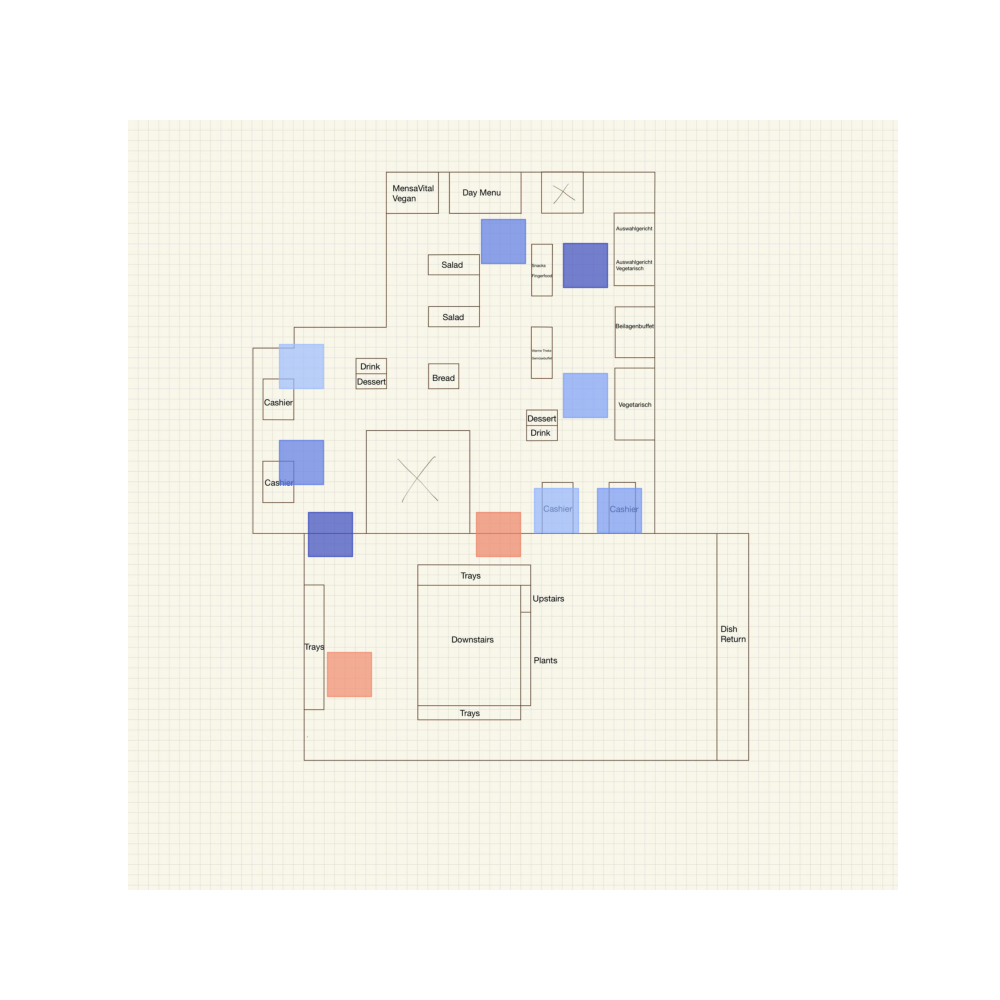

In [34]:
# Test one timeframe
tf = {}
for spot in keys_second_day:
    tf[spot] = interpolated_data[spot][20]
image = plot_tf(tf)
display(image)

In [23]:
# Collect frames for animation (unnecessary)
frames = []
for i in tqdm(range(len(interpolated_data['Day_Menu'])), desc="Collecting frames"):
    tf = {}
    for spot in keys_second_day:
        tf[spot] = interpolated_data[spot][i]
    image = plot_tf(tf)
    frames.append(image)

In [24]:
matplotlib.rcParams['animation.embed_limit'] = 50000

Thoughts about the animation:
- Try different sizes of timeframes: (larger)
- low values might be too bright

In [35]:
# Create animation

values = [i for i in range(len(frames))]

fig, ax = plt.subplots(figsize=(10, 10))

def animate(i):
    ax.clear()
    ax.imshow(BACKGROUND_IMAGE)
    
    for spot in keys_second_day:
        maximum = 10
        color = plt.cm.coolwarm(interpolated_data[spot][i] / maximum)
        x, y = POINTS_COORDS[spot]
        ax.scatter(
            x, y, color=color, s=200 * 5, marker='s', alpha=0.7
        )
    ax.axis('off')
    return ax

ani = FuncAnimation(fig, animate, frames=values, interval=50, blit=False)
HTML(ani.to_jshtml())

NameError: name 'jdhdh' is not defined

In [26]:
# Save the animation as a GIF
frames[0].save('data/animation.gif', save_all=True, append_images=frames[1:], duration=50, loop=0)